In [1]:
import numpy as np
import random
import gym
import torch
import seaborn as sns
import gym_minigrid
from tqdm.notebook import tqdm
from dataclasses import dataclass

from torch import nn
import pandas as pd
from torch import optim
from typing import Any
from copy import deepcopy
# from gym.wrappers import Monitor
from collections import deque

from envs.render_utils import room_to_rgb
import os
from os import listdir
from os.path import isfile, join
import requests
import zipfile
import random
from matplotlib import pyplot as plt
from gym import spaces
from gym.utils import seeding

from collections import namedtuple
from dataclasses import dataclass
from torch.autograd import Variable

import time
import os
import gym
import json
import matplotlib as mpl

from matplotlib import animation
from IPython.display import HTML
from typing import Any
mpl.rcParams['figure.dpi']= 100

/Users/meenalp/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/meenalp/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/meenalp/opt/anaconda3/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/meenalp/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/meenalp/o

ModuleNotFoundError: No module named 'envs'

In [ ]:
from buffer_one_hot import CyclicBuffer, PrioritizedReplayBuffer, ReplayBufferGraph


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done', 'time_step'))

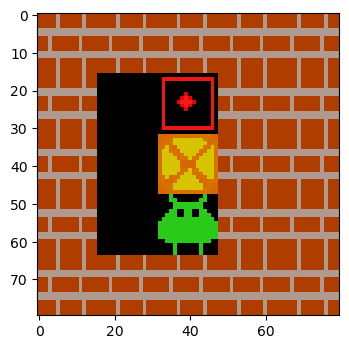

In [4]:
from envs.sokoban_env_one_hot import SokobanEnv
env = SokobanEnv(num_boxes=1, dim_room=(5,5), different = True)
env.reset()
plt.imshow(env.get_image('image'))
# ACTION_LOOKUP = {
#     0: 'push up',
#     1: 'push down',
#     2: 'push left',
#     3: 'push right',
# }

In [5]:
env.step(2)

(array([[[1, 1, 1, 1, 1],
         [1, 0, 0, 1, 1],
         [1, 0, 0, 1, 1],
         [1, 0, 0, 1, 1],
         [1, 1, 1, 1, 1]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0]]], dtype=int8),
 0.0,
 False,
 {'action.name': 'push left',
  'action.moved_player': True,
  'action.moved_box': False})

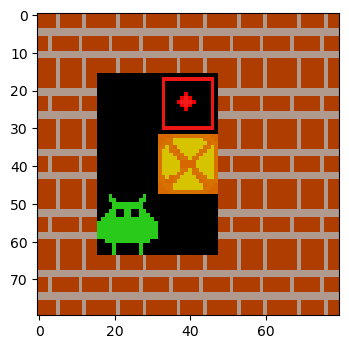

In [6]:
plt.imshow(env.get_image('image'))


In [7]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)



In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

## DQNetwork

In [9]:
# class DQNetwork(nn.Module):
#     def __init__(self, input_len, num_actions):
#         super().__init__()
#         #### A simple convoluntional network that takes
#         #### as input the observation (image), and outputs the 
#         #### Q values for each possible action.

#         self.net = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(input_len, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, num_actions),
#         )
        
# #         self.conv_net = nn.Sequential(
# #             nn.Conv2d(3, 16, (3, 3)),
# #             nn.ReLU(),
# #             nn.Conv2d(16, 32, (3, 3)),
# #             nn.ReLU(),
# #             nn.Conv2d(32, 64, (3, 3)),
# #             nn.ReLU()
# #         )
# #         self.fcs = nn.Sequential(
# #             nn.Linear(64, 64),
# #             nn.ReLU(),
# #             nn.Linear(64, action_dim)
# #         )

#     def forward(self, ob):
#         #### TODO: get the Q values for each action given the input
#         #### the input shape is: [batch_size, H, W, 3]
#         #### output shape should be: [batch_size, # of actions]    
# #         print('DQN network',ob.shape)
#         return self.net(ob)
# #         bs = ob.shape[0]
# #         ob  = torch.moveaxis(ob, 3, 1)
# #         out = self.conv_net(ob)
# #         out = self.fcs(out.view((bs, -1)))
# #         return out


In [43]:
class DQNetwork(nn.Module):
    def __init__(self, num_actions):
        super().__init__()
    
        
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(4, 16, (5, 5), stride = 1, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride = 1, padding = 1),
            nn.Conv2d(16, 16, (2, 2), stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 1, (2, 2)),
            nn.ReLU()
        )
        
        self.actor = nn.Sequential(
            nn.Linear(49, 16),
#             nn.Linear(36, 16),
            nn.ReLU(),
            nn.Linear(16, num_actions),
            nn.Softmax()
        )

    def forward(self, obs):

        x = self.image_conv_actor(obs)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)

        return x


## DQN Agent 

In [44]:
@dataclass
class DQNAgent:
    env: gym.Env
    name: str
    learning_rate: float
    gamma: float
    capacity: int
    initial_epsilon: float
    min_epsilon: float
    max_epsilon_decay_steps: int
    warmup_steps: int
    batch_size: int
    target_update_freq: int
    verbose_buffer: bool
    buffer_type: str
    eta: float
    vertex_dim: int
    enable_double_q: bool = False
    disable_target_net: bool = False
    device: str = None
    tau: float = 0.995

    def __post_init__(self):
        self.reset()

    def reset(self):
        if self.device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'        
        
        input_len = self.env.dim_room[0]**2
    
        self.qnet = DQNetwork(num_actions = self.env.action_space.n).to(self.device)
        self.target_qnet = DQNetwork(num_actions = self.env.action_space.n).to(self.device)
        self.target_qnet.load_state_dict(self.qnet.state_dict())
        self.target_qnet.eval()
#         self.memory = CyclicBuffer(self.memory_size)
        self.optim = optim.Adam(self.qnet.parameters(), lr = self.learning_rate)

        if self.buffer_type == 'cyclic':
             self.buffer = CyclicBuffer(self.capacity)
        else:
            self.buffer = ReplayBufferGraph(max_transitions = self.capacity, 
                                            verbose = self.verbose_buffer,
                                            state_dim = env.dim_room[0]**2,
                                            vertex_dim = self.vertex_dim)
            
            self.per_buffer = PrioritizedReplayBuffer(self.capacity)
        
        ####
        self.loss_criterion = nn.HuberLoss()
        self.epsilon = self.initial_epsilon
        self.ep_reduction = (self.epsilon - self.min_epsilon) / float(self.max_epsilon_decay_steps)
        if self.disable_target_net:
            self.target_update_freq = 1

    @torch.no_grad()
    def get_action(self, ob, greedy_only=False):
        ob = torch.from_numpy(np.expand_dims(ob, axis=0)).float().to(self.device)
        q_val = self.qnet(ob)
        action = self.epsilon_greedy_policy(q_val, greedy_only=greedy_only)
        return action

    def epsilon_greedy_policy(self, q_values, greedy_only=False):
        max_qval = torch.max(q_values[0])
        max_actions = (q_values[0] >= (max_qval-1e-6)).cpu().detach().float().numpy()
        best_action = np.random.choice(np.arange(0, env.action_space.n), p=max_actions/np.sum(max_actions))
        
        if greedy_only:
            return int(best_action)

        if np.random.random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = int(best_action)

        return action
    
    def get_sample(self, buffer_type, eta = None):
        
        if eta is None:
            eta = self.eta
        
        if buffer_type == 'cyclic':
            if len(self.buffer) < self.warmup_steps:
                return None

        else:
            if len(self.buffer.batch_queue) < self.batch_size:
                return None
            if (eta > 1e-5) and (len(self.per_buffer) < self.batch_size):
                return None
            
        info = (0, None, None)
        if buffer_type == 'cyclic':
            obs, actions, rewards, next_obs, dones = self.buffer.sample(self.batch_size)
        else:
        
            per_batch_size = int(eta*self.batch_size)
            ter_batch_size = self.batch_size - per_batch_size
            obs, actions, rewards, next_obs, dones = self.buffer.sample(ter_batch_size)
        
            if per_batch_size > 0:
                obs_per, actions_per, rewards_per, next_obs_per, \
                dones_per, idxs, is_weights = self.per_buffer.sample(per_batch_size)
                
                obs = np.concatenate((obs, obs_per), axis = 0)
                actions = np.concatenate((actions, actions_per), axis = 0)
                rewards = np.concatenate((rewards, rewards_per), axis = 0)
                next_obs = np.concatenate((next_obs, next_obs_per), axis = 0)
                dones = np.concatenate((dones, dones_per), axis = 0)
                
                info = (per_batch_size, idxs, is_weights)
        
          
        obs = torch.from_numpy(obs).float().to(self.device)
        actions = torch.from_numpy(actions).reshape((self.batch_size, 1)).long().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        next_obs = torch.from_numpy(next_obs).float().to(self.device)
        dones = torch.from_numpy(dones).float().to(self.device)
        
        return (obs, actions, rewards, next_obs, dones), info

                
    def update_Q(self):

        sample = self.get_sample(buffer_type = self.buffer_type)
        if sample is None:
            return False
        
        obs, actions, rewards, next_obs, dones = sample[0]
        per_batch_size, idxs, is_weights = sample[1]

        Q_s_a = self.qnet(obs).gather(1, actions).flatten()

        best_vals, best_actions = torch.max(self.target_qnet(next_obs), dim = 1)
        if self.enable_double_q:
            best_actions = best_actions.unsqueeze(1)
            best_vals_2 = self.qnet(next_obs).gather(1, best_actions).flatten()
            best_vals = torch.min(best_vals, best_vals_2).detach()

        ##### TODO: get the target Q value from the bellman equation
        target_qval = rewards + (1-dones)* self.gamma * best_vals
        
        
        weights = torch.ones(self.batch_size).float().to(self.device)
        if per_batch_size > 0:
            errors = np.abs(torch.abs(Q_s_a - target_qval).detach().numpy())
            self.per_buffer.update_priorities(idxs, errors[-per_batch_size:]+ 0.001)
            
            is_weights = torch.from_numpy(is_weights).float().to(self.device)
            weights[-per_batch_size:] = is_weights
            
            
        ##### TODO: update the Q network (i.e,. calculate the loss, take a gradient step)
        self.optim.zero_grad()
        loss = self.loss_criterion(Q_s_a*weights, target_qval*weights)
        loss.backward()
        self.optim.step()
        ######

        return True
    

    def pretrain_Q_step(self, max_steps = 10000):
        
        steps = 0
        while steps < max_steps:
            if steps%1000 == 999:
                print(f'steps:{steps}')
            sample = self.get_sample(buffer_type = self.buffer_type, eta = 0.999)
            if sample is None:
                break

            obs, actions, rewards, next_obs, dones = sample[0]
            batch_size = obs.shape[0]
            target_vals = torch.zeros(batch_size)

            for i in range(batch_size):
                next_state = next_obs[i]

                x, y = np.where((next_state== 2))
                goals = set(zip(x,y))

                mask = self.env.get_allowed_cells(goals, next_state)

                value = 0
                boxes_x, boxes_y = np.where((next_state == 3) + (next_state == 4))
                box_locations = set(zip(boxes_x, boxes_y))
                for box in box_locations:
                    row, col = box
                    box_reward = mask[row, col]
                    if box_reward < 0:
                        value = -10.0
                    else:
                        value += box_reward

                target_vals[i] = value


            target_qval = rewards + (1-dones) * self.gamma * target_vals

            Q_s_a = self.qnet(obs).gather(1, actions).flatten()
            self.optim.zero_grad()
            loss = self.loss_criterion(Q_s_a, target_qval.detach())
            loss.backward()
            self.optim.step()
            
            steps += 1
            ######

        self.target_qnet.load_state_dict(self.qnet.state_dict())
        
        return steps
    
    def decay_epsilon(self):
        #### TODO: linearly decay epsilon
        self.epsilon = max(self.min_epsilon, self.epsilon - self.ep_reduction)
    
    def update_target_qnet(self, step, soft=True):
        if not soft:
            if step % self.target_update_freq == 0:
                #### TODO: update the target Q function in a "hard" way
                #### copy the parameter values in self.qnet into self.target_qnet
                self.target_qnet.load_state_dict(self.qnet.state_dict())
        else:
            #### TODO: soft update on taget Q network.
            for target_qnet_param, qnet_param in zip(self.target_qnet.parameters(), 
                                                     self.qnet.parameters()):
                new_val = self.tau*target_qnet_param.data + (1-self.tau)*qnet_param.data 
                target_qnet_param.data.copy_(new_val)


In [45]:
# you don't need to modify the following code.
@dataclass
class DQNEngine:
    env: gym.Env
    agent: Any
    max_steps: int
    smooth_len: int
    update_freq: int
    show_progress: bool = False
    max_pretrain_steps: int = 0

    def test(self, env=None, render=False):
        env = self.env if env is None else env
        ob = env.reset()
        ret = 0
        while True:
            if render:
                env.render()
            action = self.agent.get_action(ob, greedy_only=True)
            next_ob, reward, done, info = env.step(action)
            ret += reward
            ob = next_ob
            if done:
                break
#         return int(not info["maxsteps_used"])
        return int(info["all_boxes_on_target"])
#         return ret
    
    def run(self, n_runs=1):
        rewards = []
        log = []
        log_updates = []

        for i in tqdm(range(n_runs), desc='Runs'):

            ep_rewards = []
            ep_current_rewards = []
            ep_steps = []
            ep_updates = []
            self.agent.reset()
            total_updates = 0
            # we plot the smoothed return values
            smooth_ep_return = deque(maxlen=self.smooth_len)
            state = self.env.reset()
            ret = 0
            num_ep = 0

            smooth_test_return = deque(maxlen=self.smooth_len)
            ep_test_return = []
            
            pretrained_steps = 0
            
            pbar = tqdm(range(self.max_steps), desc='Step')
            for t in pbar:
                if t < self.agent.warmup_steps:
                    action = self.env.action_space.sample()
                else:
                    action = self.agent.get_action(state)
                    
                next_state, reward, done, info = self.env.step(action)
                true_done = done and info["all_boxes_on_target"]


                if self.agent.buffer_type == 'cyclic':
                    self.agent.buffer.append((state, action, reward, next_state, true_done))
                    if t%self.update_freq == 0:
#                         print(pretrained_steps, self.max_pretrain_steps, pretrained_steps < self.max_pretrain_steps)
                        if pretrained_steps < self.max_pretrain_steps:
                            pretrained_steps += self.agent.pretrain_Q_step(self.max_pretrain_steps)
                        else:
                            success = self.agent.update_Q()
                            total_updates += int(success)
                else:
                    if true_done:
                        self.agent.buffer.add_to_terminal_vertices(next_state)

                    state_array = np.array(state)
                    next_state_array = np.array(next_state)
                    self.agent.buffer.append((state_array, action, reward, next_state_array, true_done, t))
                    self.agent.per_buffer.append((state_array, action, reward, next_state_array, true_done))
                    
                    ########################################################            
                    if (self.agent.eta >= 1) or len(self.agent.buffer.terminal_vertices) > 0:
                        if self.agent.eta < 1:
                            while (t > self.agent.warmup_steps) and (len(self.agent.buffer.batch_queue) < self.agent.batch_size):
                                result = self.agent.buffer.step_reverse_BFS()
#                                 print(f'terminal: {self.agent.buffer.terminal_vertices}')
        #                         print('\n')
                                if not result:
                                    break

                        if t > self.agent.warmup_steps:
                            if t%self.update_freq == 0:
                                
                                if pretrained_steps < self.max_pretrain_steps:
                                    pretrained_steps += self.agent.pretrain_Q_step()
                                else:
                                    success = self.agent.update_Q()
                                    total_updates += int(success)
                    ########################################################

                ret += reward
                state = next_state
                
                if done:
                    
                    test_ret = self.test()
                    state = self.env.reset()
                    smooth_ep_return.append(ret)
                    ep_rewards.append(np.mean(smooth_ep_return))
                    ep_steps.append(t)
                    ep_updates.append(total_updates)
                    ep_current_rewards.append(ret)

                    num_ep += 1
                        
                    smooth_test_return.append(test_ret)
                    ep_test_return.append(np.mean(smooth_test_return))
                            
                    pbar.set_postfix({'step':t,'num_updates': total_updates, 'smooth_reward':np.mean(smooth_ep_return),
                        'reward':ret, 'test_return': np.mean(smooth_test_return)})
                            
                    ret = 0
                            
                self.agent.decay_epsilon()
                self.agent.update_target_qnet(t, soft=not self.agent.disable_target_net)

#                 pbar.set_postfix(data)
                
            rewards.append(ep_rewards)
        
            interp_test_returns = np.interp(np.arange(self.max_steps), ep_steps, ep_test_return)
            run_log2 = pd.DataFrame({'Test return': interp_test_returns[self.agent.warmup_steps:],
                                     'Steps': np.arange(self.max_steps)[self.agent.warmup_steps:],
                                     'buffer_type': self.agent.buffer_type[self.agent.warmup_steps:],
                                     'eta':str(self.agent.eta),
                                     'agent': self.agent.name,
                                     'epsilon': self.agent.initial_epsilon
                                    })
            
            run_log = pd.DataFrame({'return': ep_rewards, 
                                    'current_rewards': ep_current_rewards,
                                    'steps': ep_steps,
                                    'num_updates': ep_updates,
                                    'episode': np.arange(len(ep_rewards)), 
                                    'buffer_type': self.agent.buffer_type,
                                    'epsilon': self.agent.initial_epsilon,
                                    'test_rets': ep_test_return,
                                    'agent': self.agent.name})
            log.append(run_log)
            log_updates.append(run_log2)
#             seed = np.random.randint(1,10)
#             set_random_seed(seed=seed)
            
        return log, log_updates


In [35]:
def dqn_sweep(env, agents, engine_config, n_runs=1):
    logs = dict()
    for agent in agents:
#         seed = 0
#         set_random_seed(seed=seed)
        engine = DQNEngine(env=agent.env, agent=agent, **engine_config)
        _, ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        logs[agent.name] = ep_log
        
    logs = pd.concat(logs, ignore_index=True)
    return logs


max_steps = 15000
engine_config = {'update_freq' : 2,
                 'max_steps':max_steps, 
                 'show_progress':True, 
                 'smooth_len':1000}

def agent_config(env,
                 name,
                 eta = 0.1,
                 vertex_dim = 1,
                 buffer_type = 'ter',
                 learning_rate = 3e-4,
                 gamma =0.99,
                 warmup_steps =2000,
                 capacity =20000,
                 initial_epsilon =0.9,
                 min_epsilon =0.01,
                 batch_size = 32,
                 max_epsilon_decay_steps =max_steps,
                 target_update_freq = 500,
                 device =None,
                 disable_target_net =False,
                 enable_double_q =True,
                 verbose_buffer =False):
        return {
            'env' : env ,
            'name': name ,
            'eta' : eta ,
            'buffer_type' : buffer_type ,
            'learning_rate': learning_rate ,
            'gamma' : gamma ,
            'warmup_steps':  warmup_steps ,
            'capacity' : capacity ,
            'initial_epsilon':  initial_epsilon ,
            'min_epsilon':  min_epsilon ,
            'batch_size':  batch_size ,
            'max_epsilon_decay_steps':  max_epsilon_decay_steps ,
            'target_update_freq' : target_update_freq ,
            'device' : device ,
            'vertex_dim': vertex_dim,
            'disable_target_net':  disable_target_net ,
            'enable_double_q':  enable_double_q ,
            'verbose_buffer' : verbose_buffer}

env = SokobanEnv(num_boxes=1, dim_room=(5,5), different = True)

config1 = agent_config(env = env, buffer_type = 'ter', name = 'TER_0.1', eta = 0.1)
config2 = agent_config(env = env, buffer_type = 'ter', name = 'TER_0.99', eta = 0.99)
config3 = agent_config(env = env, buffer_type = 'cyclic', name = 'cyclic')
agents = [DQNAgent(**config1), DQNAgent(**config2), DQNAgent(**config3)]

eps_logs_5_1 = dqn_sweep(env, agents, engine_config, n_runs=2)


# env = SokobanEnv(num_boxes=2, dim_room=(5,5), different = True)

# config1 = agent_config(env = env, buffer_type = 'ter', name = 'TER_0.1', eta = 0.1)
# config2 = agent_config(env = env, buffer_type = 'ter', name = 'TER_0.99', eta = 0.99)
# config3 = agent_config(env = env, buffer_type = 'cyclic', name = 'cyclic')
# agents = [DQNAgent(**config1)]#, DQNAgent(**config2), DQNAgent(**config3)]

# eps_logs_5_2 = dqn_sweep(env, agents, engine_config, n_runs=1)



[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated 

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated 

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated 

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated 

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#2) to place 1 player and 1 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#2) to place 1 player and 1 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

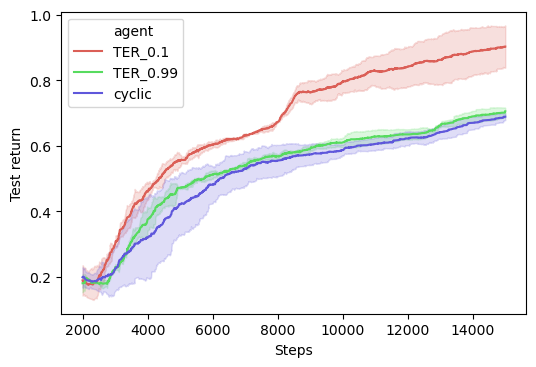

In [36]:

plot(eps_logs_5_1, x_key='Steps', y_key='Test return', legend_key='agent', 
     estimator='mean', ci='sd', palette = sns.color_palette("hls", len(agents)))


In [40]:
max_steps = 20000
engine_config = {'update_freq' : 2,
                 'max_steps':max_steps, 
                 'show_progress':True, 
                 'smooth_len':1000}

env = SokobanEnv(num_boxes=2, dim_room=(5,5), different = True)

seed = 0
set_random_seed(seed)

config1 = agent_config(env = env, buffer_type = 'ter', name = 'TER_0.1', eta = 0.1, max_epsilon_decay_steps=15000)
config2 = agent_config(env = env, buffer_type = 'ter', name = 'TER_0.99', eta = 0.99, max_epsilon_decay_steps=15000)
config3 = agent_config(env = env, buffer_type = 'cyclic', name = 'cyclic', max_epsilon_decay_steps=15000)
agents = [DQNAgent(**config1), DQNAgent(**config2), DQNAgent(**config3)]

eps_logs_5_2 = dqn_sweep(env, agents, engine_config, n_runs=3)


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .


[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .


/Users/meenalp/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player 

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score =

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spo

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#2) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#2) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spo

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player 

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated 

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player 

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated 

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .




[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spo

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

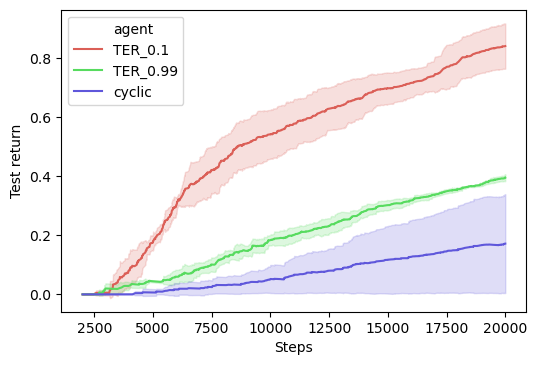

In [41]:
plot(eps_logs_5_2, x_key='Steps', y_key='Test return', legend_key='agent', 
     estimator='mean', ci='sd', palette = sns.color_palette("hls", len(agents)))

In [47]:
max_steps = 30000
engine_config = {'update_freq' : 2,
                 'max_steps':max_steps, 
                 'show_progress':True, 
                 'smooth_len':1000}

env = SokobanEnv(num_boxes=1, dim_room=(6,6), different = True)

seed = 0
set_random_seed(seed)

config1 = agent_config(env = env, buffer_type = 'ter', name = 'TER_0.1', eta = 0.1)
config2 = agent_config(env = env, buffer_type = 'ter', name = 'TER_0.99', eta = 0.99)
config3 = agent_config(env = env, buffer_type = 'cyclic', name = 'cyclic')
agents = [DQNAgent(**config1), DQNAgent(**config2), DQNAgent(**config3)]

eps_logs_5_3 = dqn_sweep(env, agents, engine_config, n_runs=2)


[SOKOBAN] Runtime Error/Warning: Not enough free spots (#2) to place 1 player and 1 boxes.
[SOKOBAN] Retry . . .



[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .



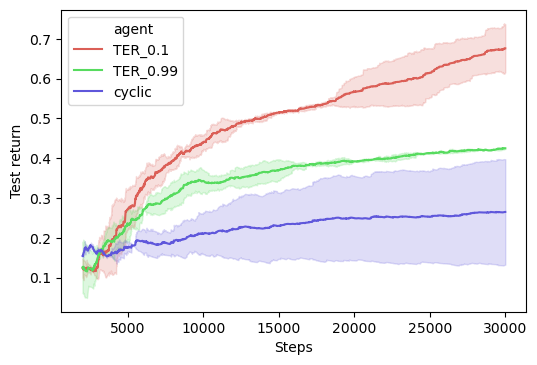

In [48]:
plot(eps_logs_5_3, x_key='Steps', y_key='Test return', legend_key='agent', 
     estimator='mean', ci='sd', palette = sns.color_palette("hls", len(agents)))

In [50]:
max_steps = 100000
engine_config = {'update_freq' : 2,
                 'max_steps':max_steps, 
                 'show_progress':True, 
                 'smooth_len':1000}

env = SokobanEnv(num_boxes=2, dim_room=(6,6), different = True)

seed = 0
set_random_seed(seed)

config1 = agent_config(env = env, buffer_type = 'ter', name = 'TER_0.1', eta = 0.1)
config2 = agent_config(env = env, buffer_type = 'ter', name = 'TER_0.99', eta = 0.99)
config3 = agent_config(env = env, buffer_type = 'cyclic', name = 'cyclic')
agents = [DQNAgent(**config1), DQNAgent(**config2), DQNAgent(**config3)]

eps_logs_6_2 = dqn_sweep(env, agents, engine_config, n_runs=2)


[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player 

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

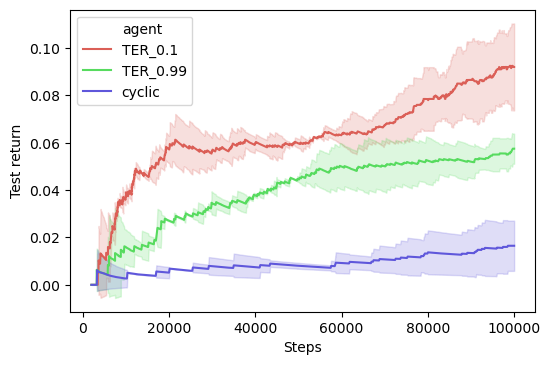

In [51]:
plot(eps_logs_6_2, x_key='Steps', y_key='Test return', legend_key='agent', 
     estimator='mean', ci='sd', palette = sns.color_palette("hls", len(agents)))

In [68]:
def plot(logs, x_key, y_key, legend_key, ax, title, **kwargs):
#     sns.set(rc = {'figure.figsize':(4,4)})
    nums = len(logs[legend_key].unique())
    palette = sns.color_palette("hls", nums)
    if 'palette' not in kwargs:
        kwargs['palette'] = palette
    ax = sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, ax = ax, **kwargs)
    ax.set(title = title)
    return ax


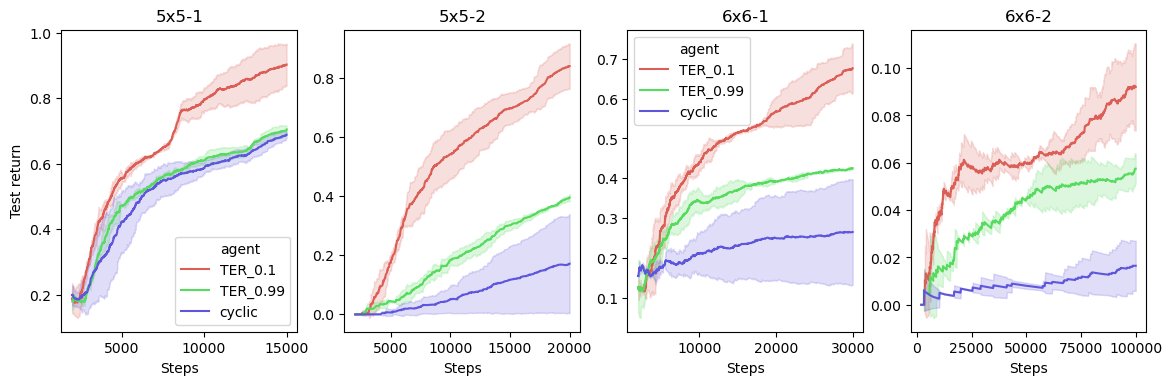

In [77]:
fig, axes = plt.subplots(1, 4, figsize = (14, 4))
ax1 = plot(eps_logs_5_1, x_key='Steps', y_key='Test return', legend_key='agent', 
     estimator='mean', ci='sd', palette = sns.color_palette("hls", len(agents)),
    ax = axes[0], title = '5x5-1')
ax2 = plot(eps_logs_5_2, x_key='Steps', y_key='Test return', legend_key='agent', 
     estimator='mean', ci='sd', palette = sns.color_palette("hls", len(agents)),
    ax = axes[1], title = '5x5-2')
ax2.set(ylabel = '')
ax2.legend_.remove()
ax3= plot(eps_logs_5_3, x_key='Steps', y_key='Test return', legend_key='agent', 
     estimator='mean', ci='sd', palette = sns.color_palette("hls", len(agents)),
    ax = axes[2], title = '6x6-1')
ax3.set(ylabel = '')
ax4 = plot(eps_logs_6_2, x_key='Steps', y_key='Test return', legend_key='agent', 
     estimator='mean', ci='sd', palette = sns.color_palette("hls", len(agents)),
    ax = axes[3], title = '6x6-2')
ax4.set(ylabel = '')
ax4.legend_.remove()

In [ ]:
class AgentConfig:
    
    def __init__(self,
                 env,
                 name,
                 eta = 0.1,
                 buffer_type = 'ter',
                 learning_rate = 3e-4,
                 gamma =0.99,
                 warmup_steps =500,
                 capacity =200000,
                 initial_epsilon =1.,
                 min_epsilon =0.01,
                 batch_size = 32,
                 max_epsilon_decay_steps =50000,
                 target_update_freq =2000,
                 device =None,
                 disable_target_net =False,
                 enable_double_q =True,
                 verbose_buffer =False
                ):
        self.env = env
        self.name = name
        self.eta = eta
        self.buffer_type = buffer_type
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.warmup_steps = warmup_steps
        self.capacity = capacity
        self.initial_epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.max_epsilon_decay_steps = max_epsilon_decay_steps
        self.target_update_freq = target_update_freq
        self.device = device
        self.disable_target_net = disable_target_net
        self.enable_double_q = enable_double_q
        self.verbose_buffer = verbose_buffer
    
    def get_config(self):
        return {
            'env' : self.env 
            'name': self.name 
            'eta' : self.eta 
            'buffer_type' : self.buffer_type 
            'learning_rate': self.learning_rate 
            'gamma' : self.gamma 
            'warmup_steps':  self.warmup_steps 
            'capacity' : self.capacity 
            'initial_epsilon':  self.initial_epsilon 
            'min_epsilon':  self.min_epsilon 
            'batch_size':  self.batch_size 
            'max_epsilon_decay_steps':  self.max_epsilon_decay_steps 
            'target_update_freq' : self.target_update_freq 
            'device' : self.device 
            'disable_target_net':  self.disable_target_net 
            'enable_double_q':  self.enable_double_q 
            'verbose_buffer' : self.verbose_buffer 
            
        }


In [ ]:

seed = 0
set_random_seed(seed=seed)
buffer = 'ter'
etas = [0.1]

eps_logs = dqn_sweep(env,
                   n_runs=1,
                   buffer = buffer,
                   max_steps=15000, 
                   epsilon=0.9, 
                   T_warmup = 5000, 
                   batch_size = 32, 
                   smooth_len = 100,
                   capacity = 100000, 
                   etas = etas)

In [ ]:
wall goal box player

In [17]:

x, y = np.where((env.room_fixed== 2))
goals = set(zip(x,y))

mask = env.get_allowed_cells(goals, env.room_state)

value = 0
boxes_x, boxes_y = np.where((env.room_state == 3) + (env.room_state == 4))
box_locations = set(zip(boxes_x, boxes_y))
for box in box_locations:
    row, col = box
    box_reward = mask[row, col]
    if box_reward < 0:
        value = -10.0
    else:
        value += box_reward

target_vals[i] = value


NameError: name 'target_vals' is not defined